In [ ]:
import faiss
import tempfile
from keras.preprocessing import image
import numpy as np
import urllib
from utils import display_from_path, display_from_url
from matplotlib import pyplot as plt


class NearestNeighborsIndex:
    def __init__(self, representations, paths, model, preprocessor, model_input_size=(224, 224)):
        self.index = faiss.IndexFlatL2(representations.shape[1])
        self.index.add(representations.astype(np.float32))
        print("{}/{} documents indexed".format(self.index.ntotal,
                                               representations.shape[0]))
        self.paths = paths
        self.model = model
        self.preprocessor = preprocessor
        self.model_input_size = model_input_size

    def _preprocess_and_predict(self, img):
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = self.preprocessor(x)
        return self.model.predict(x)

    def search(self, x, k=5):
        d, ixs = self.index.search(x, k)
        paths = [self.paths[ix] for ix in ixs[0]]
        return d, paths

    def search_from_path(self, path, k=5):
        img = image.load_img(path, target_size=self.model_input_size)
        x = self._preprocess_and_predict(img)
        return self.search(x, k)

    def search_from_url(self, url, k=5):
        with tempfile.NamedTemporaryFile() as f:
            urllib.request.urlretrieve(url, f.name)
            img = image.load_img(f.name, target_size=self.model_input_size)
            x = self._preprocess_and_predict(img)
            return self.search(x, k)
        
    def search_and_plot_from_url(self, url, k=5):
        _, neighbor_paths = self.search_from_url(url, k)
        f, axs = plt.subplots(1, k + 1, figsize=(3*k, 10))
        display_from_url(url, axs[0])
        axs[0].axis('off')
        for ax, neighbor_path in zip(axs[1:], neighbor_paths):
            display_from_path(neighbor_path, ax)
            ax.axis('off')
        return neighbor_paths

    def search_and_plot_from_path(self, path, k=5):
        _, neighbor_paths = self.search_from_path(path, k)
        f, axs = plt.subplots(1, k + 1, figsize=(3*k, 10))
        display_from_path(path, axs[0])
        for ax, neighbor_path in zip(axs[1:], neighbor_paths):
            display_from_path(neighbor_path, ax)  
        return neighbor_paths

In [14]:
features_arr = np.load("dataset/representations.npy")
paths = np.load("dataset/representations_paths.npy", allow_pickle=True)

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False, pooling='avg')

nn = NearestNeighborsIndex(features_arr, paths, model, preprocess_input)

100/100 documents indexed


['/Users/arnau.tibau/Projects/ml-in-prod-course-materials/reproducible/1_computation_dags/playtime/solution/dataset/2004 toyota sienna/4.BG100088_3162fe.png',
 '/Users/arnau.tibau/Projects/ml-in-prod-course-materials/reproducible/1_computation_dags/playtime/solution/dataset/2004 toyota sienna/6.BG100079_14fe0e.png',
 '/Users/arnau.tibau/Projects/ml-in-prod-course-materials/reproducible/1_computation_dags/playtime/solution/dataset/2004 toyota sienna/2.BG100107_3d4362.png',
 '/Users/arnau.tibau/Projects/ml-in-prod-course-materials/reproducible/1_computation_dags/playtime/solution/dataset/2002 bentley arnage/1.Screen-Shot-2016-12-08-at-11.40.54-AM-940x575.png',
 '/Users/arnau.tibau/Projects/ml-in-prod-course-materials/reproducible/1_computation_dags/playtime/solution/dataset/2002 bentley arnage/6.5d0311b3e9802a1472949411da5acb69.png']

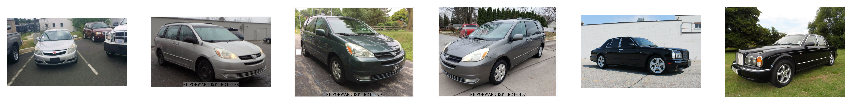

In [15]:
nn.search_and_plot_from_url('https://img.letgo.com/images/b3/9a/01/67/b39a0167d370e3a220982d94c99bceb0.jpeg?impolicy=img_600')

['/Users/arnau.tibau/Projects/ml-in-prod-course-materials/reproducible/1_computation_dags/playtime/solution/dataset/2003 ski-doo summit 800 highmark/1.2004-Ski-Doo-800-Highmark-Extreme-SOLD.png',
 '/Users/arnau.tibau/Projects/ml-in-prod-course-materials/reproducible/1_computation_dags/playtime/solution/dataset/2007 arctic cat 650 h1 4x4 auto trv plus le/7.arcticcat.png',
 '/Users/arnau.tibau/Projects/ml-in-prod-course-materials/reproducible/1_computation_dags/playtime/solution/dataset/2002 ski-doo legend 800 se/10.ZR%20120.PNG',
 '/Users/arnau.tibau/Projects/ml-in-prod-course-materials/reproducible/1_computation_dags/playtime/solution/dataset/2003 ski-doo summit 800 highmark/2.EC12545A-D3E4-4C9D-B5FA-E25491E342DD.png',
 '/Users/arnau.tibau/Projects/ml-in-prod-course-materials/reproducible/1_computation_dags/playtime/solution/dataset/2007 argo response 8x8/8.GOTZ-ohne-Rand.png']

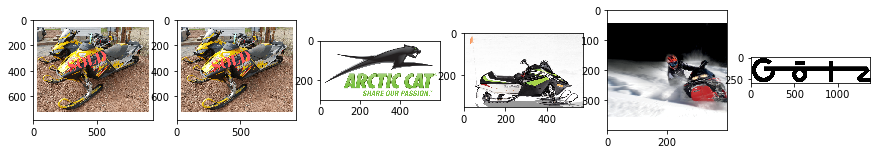

In [16]:
nn.search_and_plot_from_path(paths[10])